In [1]:
import nltk
import requests

import pandas as pd
from pandas import DataFrame
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

import matplotlib
import matplotlib.pyplot as plt

import re

In [2]:
# Criar função para requisitar a etiquetagem do PortService-Br
    # Importante observar que, quando a palavra é desconhecida, o PortService-Br não etiqueta adequadamente a palavra
    # Palavras desconhecidas incluem nomes próprios, abreviações, palavras com erros de ortografia, e caracteres especiais e sinais de pontuação que não são conhecidos pelo etiquetador Freeling
# Criar função para somar as etiquetas por tipo

# Incluir dados das etiquetas no DataFrame
# Criar função para plotar os valores num gráfico usando Matplotlib

# Aplicar os procedimentos em strings com stopwords
# Remover as stopwords
# Aplicar os procedimentos em strings sem stopwords

# O problema que surgiu no gráfico tem relação com a etiquetagem repetida das palavras. Existe uma diferença entre
# etiquetar as palavras antes ou depois da remoção das stopwords. Para resultados mais confiáveis, é melhor
# que a etiquetagem seja feita antes de tal remoção.

In [3]:
def requestPosTagging(text):
    try:
        payload = {'texto': str(text)}
        response = requests.get('http://portservice.pythonanywhere.com/analise/morfossintatica/freeling', params=payload).json()
    except:
        print("Characters: "+str(len(text))+"; Words: "+str(len(word_tokenize(text)))+"; Text: "+str(text)+"\n")
    return response

def sumDifferentTags(jsonObject):    
    tagsDictionary = {
        'A': 0,
        'C': 0,
        'D': 0,
        'N': 0,
        'P': 0,
        'R': 0,
        'S': 0,
        'V': 0,
        'Z': 0,
        'W': 0,
        'I': 0,
        'F': 0,
        'UNKNOWN': 0,
        'TOTAL': 0
    }
    
    tagsDictionary['TOTAL'] = len(jsonObject)
    
    for word in jsonObject:
        if word['lemma'] != '<unknown>':
            if word['poss'][0] in tagsDictionary:
                tagsDictionary[word['poss'][0]] += 1
            else:
                tagsDictionary['UNKNOWN'] += 1
        else:
            tagsDictionary['UNKNOWN'] += 1

    return tagsDictionary

In [4]:
def cleanDataframeColumns(dataframe):
    numberList = []
    textList = []
    percentageList = []
    i = 0
    while i < dataframe.shape[0]:
        numberList.append(0)
        textList.append('')
        percentageList.append(0.0)
        i+=1
    
    textArrayBefore = ['extendedSynopsis']
    for column in textArrayBefore:
        dataframe[column] = textList
    
    numberArrayBefore = ['adjective_before','conjunction_before','determiner_before','noun_before','pronoun_before','adverb_before','adposition_before','verb_before','number_before','date_before','interjection_before','punctuation_before','unknown_before','total_before']
    for column in numberArrayBefore:
        dataframe[column] = numberList
        
    textArrayAfter = ['synopsisWithoutStopwords']
    for column in textArrayAfter:
        dataframe[column] = textList
    
    numberArrayAfter = ['adjective_after','conjunction_after','determiner_after','noun_after','pronoun_after','adverb_after','adposition_after','verb_after','number_after','date_after','interjection_after','punctuation_after','unknown_after','total_after']
    for column in numberArrayAfter:
        dataframe[column] = numberList
    
    dataframe['percentageOfUnknownWords'] = percentageList

In [5]:
def executePosTagging(dataframe):
    i = 0
    while i < dataframe.shape[0]:
        text = dataframe.sinopse.iloc[i]
        
        try:
            result = requestPosTagging(text)
            dictionary = sumDifferentTags(result)

            dataframe.extendedSynopsis.iloc[i] = recreateSynopsis(result)

            dataframe.adjective_before.iloc[i] = dictionary.get('A')
            dataframe.conjunction_before.iloc[i] = dictionary.get('C')
            dataframe.determiner_before.iloc[i] = dictionary.get('D')
            dataframe.noun_before.iloc[i] = dictionary.get('N')
            dataframe.pronoun_before.iloc[i] = dictionary.get('P')
            dataframe.adverb_before.iloc[i] = dictionary.get('R')
            dataframe.adposition_before.iloc[i] = dictionary.get('S')
            dataframe.verb_before.iloc[i] = dictionary.get('V')
            dataframe.number_before.iloc[i] = dictionary.get('Z')
            dataframe.date_before.iloc[i] = dictionary.get('W')
            dataframe.interjection_before.iloc[i] = dictionary.get('I')
            dataframe.punctuation_before.iloc[i] = dictionary.get('F')
            dataframe.unknown_before.iloc[i] = dictionary.get('UNKNOWN')
            dataframe.total_before.iloc[i] = dictionary.get('TOTAL')

            resultWithoutStopwords = removeStopwordsFromSynopsis(result)
            dictionaryWithoutStopwords = sumDifferentTags(resultWithoutStopwords)

            dataframe.synopsisWithoutStopwords.iloc[i] = recreateSynopsis(resultWithoutStopwords)

            dataframe.adjective_after.iloc[i] = dictionaryWithoutStopwords.get('A')
            dataframe.conjunction_after.iloc[i] = dictionaryWithoutStopwords.get('C')
            dataframe.determiner_after.iloc[i] = dictionaryWithoutStopwords.get('D')
            dataframe.noun_after.iloc[i] = dictionaryWithoutStopwords.get('N')
            dataframe.pronoun_after.iloc[i] = dictionaryWithoutStopwords.get('P')
            dataframe.adverb_after.iloc[i] = dictionaryWithoutStopwords.get('R')
            dataframe.adposition_after.iloc[i] = dictionaryWithoutStopwords.get('S')
            dataframe.verb_after.iloc[i] = dictionaryWithoutStopwords.get('V')
            dataframe.number_after.iloc[i] = dictionaryWithoutStopwords.get('Z')
            dataframe.date_after.iloc[i] = dictionaryWithoutStopwords.get('W')
            dataframe.interjection_after.iloc[i] = dictionaryWithoutStopwords.get('I')
            dataframe.punctuation_after.iloc[i] = dictionaryWithoutStopwords.get('F')
            dataframe.unknown_after.iloc[i] = dictionaryWithoutStopwords.get('UNKNOWN')
            dataframe.total_after.iloc[i] = dictionaryWithoutStopwords.get('TOTAL')

            dataframe.percentageOfUnknownWords.iloc[i] = (dictionary.get('UNKNOWN')/dictionary.get('TOTAL'))*100
        except:
            pass
        
        i += 1

In [6]:
stopwordsList = stopwords.words('portuguese')

def removeStopwordsFromSynopsis(jsonObject):
    synopsisWithoutStopwords = [word for word in jsonObject if word['token'] not in stopwordsList]
    return synopsisWithoutStopwords

In [7]:
def recreateSynopsis(response):
    allWords = []
    for item in response:
        allWords.append(item['token'])
    return " ".join(allWords)

In [2]:
#Count number of characters in each string
def countCharactersInEachString(df, column):
    charactersCount = []
    for synopsis in df[column]:
        charactersCount.append(len(str(synopsis)))
    return charactersCount

#Count number of words in each string
def countWordsInEachString(df, column):
    wordsCount = []
    for synopsis in df[column]:
        words = word_tokenize(str(synopsis))
        wordsCount.append(len(words))
    return wordsCount

#Extract some basic statistics about synopsis
def extractBasicStatisticsAboutSynopsis(arrayOfSizes):
    synopsisLength = np.array(arrayOfSizes)
    basicStatistics = "\t"   
    basicStatistics += "Arithmetic Mean: " + str(np.mean(synopsisLength)) + "\n\t"
    basicStatistics += "Median: " + str(np.median(synopsisLength)) + "\n\t"
    basicStatistics += "Highest Value: " + str(np.max(synopsisLength)) + "\n\t"
    basicStatistics += "Lowest Value: " + str(np.min(synopsisLength)) + "\n\t"
    basicStatistics += "Mid-range: " + str((np.max(synopsisLength)-np.min(synopsisLength))/2) + "\n\t"
    basicStatistics += "Variance: " + str(np.var(synopsisLength,ddof=1)) + "\n\t"
    basicStatistics += "Standard Deviation: " + str(np.std(synopsisLength,ddof=1)) + "\n\t"
    return basicStatistics

def extractPercentilesAboutSynopsis(arrayOfSizes):
    synopsisLength = np.array(arrayOfSizes)
    percentiles = "Percentiles: " + "\n\t"
    count = 0.5
    while count <= 100:
        percentiles += "Percentile " + str(count) + ": " + str(np.percentile(arrayOfSizes,count)) + "\n\t"
        count += 0.5
    return percentiles

#Extract some statistics about this Dataset
def extractStatisticsFromSynopsis(dataframe, title, column):
    log = title + "\n\n"
    log += "Shape of Dataset: " + str(dataframe.shape[0]) + " rows and " + str(dataframe.shape[1]) + " columns" + "\n\n"
    log += "Statistics of Synopsis Length (Characters):" + "\n"
    charactersCount = countCharactersInEachString(dataframe, column)
    log += extractBasicStatisticsAboutSynopsis(charactersCount) + "\n"
    log += extractPercentilesAboutSynopsis(charactersCount) + "\n"
    log += "Statistics of Synopsis Length (Words):" + "\n"
    wordsCount = countWordsInEachString(dataframe, column)
    log += extractBasicStatisticsAboutSynopsis(wordsCount) + "\n"
    log += extractPercentilesAboutSynopsis(wordsCount) + "\n"
    return log

In [3]:
filePath = 'C:/Users/LuisRicardoFerraz/Documents/personal/projects/book-similarity/test/tutorial/tutorial/spiders/synopsis-preprocessing/'

In [10]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'dataSetComSinopsesLimpas.csv')
df = df.drop(['Unnamed: 0'],1)

In [11]:
cleanDataframeColumns(df)
executePosTagging(df)

C:\Users\LuisRicardoFerraz\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Characters: 8166; Words: 1376; Text: corpo presente é o mergulho de um homem em suas obsessões seu narrador atravessa ruas noites e mulheres em busca de um amor perdido ou impossível uma carmen que não é de ópera ou ficção mas da copacabana suja e sedutora cenário claustrofóbico deste primeiro romance de joão paulo cuenca tragado pelas noites ofuscado pelo sol o protagonista vive um presente contínuo e tenso em busca de sentimentos para sempre perdidos num mundo cínico demais violento demais sexualizado demais idealista a seu modo busca a pureza lambuzando se com as precariedades que a vida lhe oferece tal como os números primos que encimam os fragmentos do texto os personagens de corpo presente são divisíveis por eles mesmos e por um o que joão paulo cuenca propõe é um jogo de identidades sem vencedores ou perdedores mas com uma regra rígida a da escrita como forma de enfrentar a vida saiu na imprensa estado de minas data estatuto da solidão em seu livro de estréia joão paulo cuenca m

Characters: 3290; Words: 524; Text: a expedição solar a expedição solar é o primeiro romance do escritor antropólogo flávio c faria lançado em março de com publicação da editora planetário subsidiária da pandora books de s paulo o lançamento em brasília aconteceu no restaurante carpe diem no dia de março e na bienal do livro de são paulo em de abril embora destinado ao público adolescente o romance possui uma narrativa com forte tempero de realismo fantástico que o transforma em uma obra para todas as idades o livro descreve duas estórias paralelas que giram em torno do desaparecimento de um objeto sagrado dos incas o disco solar que de fato desapareceu durante a invasão espanhola promovida por francisco pizarro a partir de cada capítulo é dividido em duas partes sendo que uma delas acontece a partir de quando um grupo de sacerdotes incas deixa cuzco no peru e empreende uma fantástica viagem através da amazônia com o objetivo de levar esse misterioso objeto para algum lugar da floresta

Characters: 5163; Words: 872; Text: box saga crepúsculo livros crepúsculo desafiou a imaginação lua nova deixou os leitores sedentos por mais eclipse transformou a série em um fenômeno global e amanhecer é o livro que encerra a saga de paixões e perigos com um desfecho de tirar o fôlego para os fãs de stephenie meyer reunimos no box saga crepúsculo com os quatro volumes da série o livro a breve segunda vida de bree tanner uma nova perspectiva do universo de crepúsculo crepúsculo nunca pensei muito em como morreria embora nos últimos meses tivesse motivos suficientes para isso mas mesmo que tivesse pensado não teria imaginado que seria assim sem dúvida era uma boa forma de morrer no lugar de outra pessoa de alguém que eu amava nobre até isso devia contar para alguma coisa isabella swan chega à nublada e chuvosa cidadezinha de forks último lugar onde gostaria de viver tenta se adaptar à vida provinciana na qual aparentemente todos se conhecem lidar com sua constrangedora falta de coorden

Characters: 3402; Words: 552; Text:  não posso garantir que se você seguir os princípios apresentados neste livro seus filhos jamais terão problemas para dizer a verdade eu não confiaria em um escritor que fizesse tal promessa mas posso garantir que as crianças educadas segundo os princípios mostram se bem mais propensas a desenvolver hábitos saudáveis do que crianças educadas de outra forma esta não é uma opinião é um fato corroborado por fortes evidências laurence steinberg este livro é diferente de todos os outros que falam sobre a função dos pais porque se fundamenta em milhares de pesquisas bem elaboradas e tão confiáveis quanto aquelas que se destinam a testar novas drogas e projetar carros mais seguros um dos psicólogos mais conceituados dos estados unidos laurence steinberg resume e relata em linguagem simples e acessível o que os especialistas aprenderam em décadas de pesquisas abrangendo centenas de milhares de famílias são os princípios básicos para educar os filhos eles ser

Characters: 3468; Words: 577; Text:  prendê los ou soltá los ser rígido ou flexível com grande sabedoria e uma mensagem poderosa dorothy law nolte e rachel harris ensinam aos pais como se manterem ligados a seus filhos adolescentes e influir positivamente na vida deles jack canfield co autor de histórias para aquecer o coração os anos da adolescência podem ser desafiadores para pais e filhos mas é possível superar as dificuldades colocando em prática duas verdades básicas sobre a educação tratadas neste livro os pais devem dar o exemplo e manter se profundamente envolvidos com os filhos com ótimas histórias e muito bom senso este guia nos orienta sobre o que fazer para manter um canal de comunicação com nossos filhos adolescentes e assim transmitir lhes valores fundamentais como auto estima integridade respeito responsabilidade e perseverança como os jovens estão atentos à menor contradição entre o que falamos e o que fazemos a maneira como nos relacionamos com os outros e reagimos aos

Characters: 3526; Words: 587; Text: um amplo e fascinante passeio pela história recente conduzido com maestria e inconfundível senso crítico pela premiada escritora canadense crítica literária e ativista margaret atwood este é o fio condutor da coletânea de crônicas buscas curiosas com impressões sobre o fracasso e a queda de utopias coletivas ou individuais que nortearam o mundo ao longo das últimas décadas do século xx da queda do muro de berlim ao de setembro passando por episódios da infância e da adolescência da autora por ensaios sobre seus autores favoritos ou por apaixonadas defesas da causa ecológica atwood lança seu olhar cético sobre o mundo a seu redor a autora de o assassino cego descreve os ruídos as conversas e os livros que povoaram a sua casa na infância e que a estimularam a se embrenhar no universo literário sua narrativa está igualmente permeada por sua experiência na militância pelos direitos da mulher atwood recupera década a década o papel da mulher pois parte da

Characters: 4419; Words: 744; Text:  rites of spring the great war and the birth of the modern age paris de maio de première do balé a sagração da primavera quinze meses depois as principais capitais européias enviam para frentes de combate milhares de jovens dispostos a morrer em nome de uma nova era política em que a devastação e a criação trocaram de lugar passando em revista fatos como o vôo de lindbergh sobre o atlântico a publicação de nada de novo no front de remarque e a ascensão do nazismo o historiador modris eksteins descreve de forma original o que foi o período que se seguiu à primeira guerra mundial e que padrões de comportamento e intelectualidade emergiram do conflito a sagração da primavera descreve as origens o impacto e as consequências da grande guerra de o título do livro remete ao famoso balé de igor stravinsky estreado em paris pelos ballets russes de diaghilev com a brilhante performance de vaslav nijinsky em de maio de a platéia fica chocada diante do bárbaro r

Characters: 5147; Words: 879; Text: um milionário sulista passa por uma experiência espiritual profunda e ao final está tão egoísta quanto antes um magnata do mercado imobiliário endividado até a alma e em crise com o inevitável processo de envelhecimento um bem sucedido advogado negro dividido entre sua ambição e os antigos ideais do black power um rapaz branco pobre e trabalhador que descobre na filosofia estóica dos gregos antigos o antídoto moral contra os seus sucessivos fracassos esses três personagens se encontram no caldeirão racial da moderna atlanta no livro um homem por inteiro de tom wolfe considerado um dos melhores romancistas americanos da atualidade a nova obra está no topo da lista de livros mais vendidos nos estados unidos dessa vez o autor mira sua mordacidade para a sociedade do sul dos estados unidos o eixo condutor é charlie croker que enriqueceu de forma fabulosa e inescrupulosa no boom imobiliário dos anos e ex astro local do futebol americano ele tem orgulho de

Characters: 3587; Words: 627; Text:  para libertar a humanidade da dor ele próprio tinha de entender o que é sofrer cercado de luxo e riqueza protegido da realidade da vida exterior às muralhas do palácio de kapilavástu cresce um jovem príncipe o futuro sucessor do reino sem sequer sabe como vivem seus súditos e de quantas preocupações e dificuldades consiste a vida de um soberano mas intui que nasceu para cumpri uma missão na vida regida pelo carma filho do rajá suddhodana e de sua esposa maya sidarta gautama nasceu na fantástica índia no século vi a c e após atingir o estado de iluminação passa a ser denominado buda em príncipe sidarta a fuga do palácio patricia chendi começa a nos contar uma bonita história em que se mesclam a realidade possível com relação a um personagem que viveu há mais de anos e a fantasia que tem origem nas inúmeras lendas transmitidas pela tradição ao longo do tempo acompanhando a narrativa entramos no túnel do tempo além de nos tornarmos participantes do mun

Characters: 3889; Words: 693; Text: ludovico ou ludo como sua mãe sybilla o chama começou a aprender as primeiras letras e as primeiras operações matemáticas com dois anos aos quatro sybilla começou a ensinar lhe o grego que se seguiu ao italiano e ao francês aos seis anos já dominava mais de caracteres japoneses e aos fez a pergunta que o ligaria a despeito de sua educação precoce e sua espantosa erudição aos milhões de crianças nascidas de mãe solteira quem é meu pai esse é o grande trunfo de o último samurai de helen dewitt num estilo que muitas vezes à primeira vista pode parecer confuso mas que traduz de maneira brilhante a efervescência das mentes de sybilla e de ludo helen dewitt descreve o caminho que o menino faz para encontrar o pai sybilla é uma mulher que nasceu no meio oeste americano e trocou o próspero negócio paterno de motéis pelos quartos abafados de oxford em um esforço para escapar à tradição familiar de postergar os sonhos uma vez em oxford consciente de sua repuls

Characters: 4173; Words: 692; Text: com os florais perversos de madame de sade os autores ruth barros marcos gomes e heloisa campos se propuseram a criar um romance libertino nos moldes dos que eram escritos no século tão ricos em pornografia quanto em filosofia duas armas eficazes na crítica à sociedade o livro é também um grande romance histórico cuja ação vai dos anos anteriores à revolução francesa até os dias de glória de napoleão período narrado com propriedade por joséphine mulher que adquiriu sabedoria e riqueza vultosas construídas sobre os sete pecados capitais as descrições e os conceitos de época são absolutamente fidedignos pois os autores trabalharam durante mais de dois anos na pesquisa e construção do romance heloisa infelizmente morreu nos primeiros meses do trabalho o famoso marquês que deu nome ao sadismo é apenas a referência mais óbvia neste lançamento da rocco o romance é repleto de incontáveis citações homenagens e sátiras a livros filmes e personalidades conheci

Characters: 4154; Words: 689; Text: uma testemunha ocular da história assim poderia ser definida de maneira fria rápida e sintética olga yunter nascida no verão de no norte da sibéria mas ela foi muito mais do que isso em a história de olga stephanie williams conta a comovente trajetória de sua avó olga que passou por duas guerras mundiais e uma revolução alguns dos mais devastadores cruéis e sangrentos episódios do século xx o livro baseado em relatos da própria olga anotações correspondências e em uma exaustiva pesquisa traz um olhar pessoal sensível e chocante sobre acontecimentos que alteraram os rumos da história da humanidade dizendo mais do que quaisquer documentos números ou estatísticas em a história de olga três continentes duas guerras mundiais e uma revolução a saga de uma mulher pela história do século xx a jornalista stephanie williams remonta a história da avó materna que viveu alguns dos fatos históricos mais marcantes do século xx baseada em uma pesquisa que se estende

Characters: 3493; Words: 565; Text: uma das muitas histórias de heroísmo que permanecem pouco conhecidas anos após o fim da segunda guerra mundial é a dos que ajudaram a nata da intelectualidade européia da época a fugir da europa para os países norte americanos o trabalho de um grupo de americanos liderados pelo jornalista varian fry que salvou as vidas de alguns dos mais notáveis pensadores da época como o surrealista andré breton e o pintor marc chagall é lembrado em villa air bel no livro a escritora canadense rosemary sullivan faz uma minuciosa reconstituição do período de em que alguns desses refugiados ilustres ficaram hospedados com suas famílias em um casarão nos arredores da cidade francesa de marselha à espera do momento mais apropriado para deixarem a europa cerca de duas mil pessoas conseguiram deixar a europa escapando da perseguição nazista graças aos esforços de varian fry que representava uma organização humanitária norte americana comitê de resgate de emergência sem q

Characters: 3457; Words: 592; Text: em seu primeiro livro de ficção o passeador a jornalista luciana hidalgo duas vezes ganhadora do jabuti por arthur bispo do rosario o senhor do labirinto e literatura da urgência lima barreto no domínio da loucura nas categorias reportagem e teoria literária respectivamente segue a linha dos autores que viram o rio de janeiro como um grande espaço para o passeio e a observação da sociedade tendo como protagonista ninguém menos que o autor de triste fim de policarpo quaresma inspirada por obras como a alma encantadora das ruas de joão do rio e vida e morte de m j gonzaga de sá do próprio lima barreto a autora conduz o leitor por um passeio pelo rio de janeiro do bota abaixo como ficou conhecida a reforma urbana empreendida pelo prefeito pereira passos no início do século xx revisitando um período importante da história da cidade a partir do ponto de vista de um de seus maiores observadores e por meio de um enredo ficcional costurado à perfeição no liv

Characters: 4170; Words: 706; Text: autor do bestseller internacional nicolau e alexandra e da biografia ganhadora do prêmio pulitzer pedro o grande o historiador e biógrafo norte americano robert k massie retoma ao universo da rússia czarista que o consagrou com o lançamento catarina a grande retrato de uma mulher apontado como um dos destaques do ano pelo the new york times washington post e outras importantes publicações o livro ganhou o prêmio pen jacqueline bograd weld de melhor biografia publicada nos estados unidos em recebeu resenhas elogiosas dos principais veículos de imprensa e figurou nas mais importantes listas dos mais vendidos nos estados unidos catarina a grande retrato de uma mulher é antes de tudo a história de uma pessoa solitária que nunca gozou de afeto e amizade e mesmo assim e por isso mesmo viveu para amar e ser amada sentimento sublimado pela adoção da rússia como objeto de seu amor maior e que teve como reflexos sua modernização educacional e cultural e expans

Characters: 3914; Words: 671; Text: primeiro livro de neil gaiman escrito especialmente para o público juvenil coraline é também uma de suas obras mais importantes escrito para a filha holly à época com cinco anos este conto de fadas às avessas não só se tornou um clássico da literatura juvenil contemporânea como ganhou as telas de cinema de todo o mundo pelas mãos do prestigiado diretor henry selick de o estranho mundo de jack e também uma versão em graphic novel assinada pelo premiado quadrinista p craig russel que chega agora ao brasil pelo selo rocco jovens leitores em caprichada edição primeira hq do catálogo da rocco coraline graphic novel apresenta a sombria trama da menina que todos insistem em chamar de caroline com tintas mais juvenis na adaptação de russel a protagonista ganhou um ar mais teen mas sua história continua tão assustadora e fascinante quanto na versão original tudo começa com a mudança de coraline para uma antiga casa que tem por vizinhos velhinhos excêntricos e

In [37]:
df.to_csv(filePath+'dataSetComPosTaggingERemocaoDeStopWords.csv')
with open(filePath+'logDataSetComPosTaggingERemocaoDeStopWords.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - PosTagging and StopWords Removal", 'sinopse'))

In [66]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'dataSetComPosTaggingERemocaoDeStopWords.csv')
df = df.drop(['Unnamed: 0'],1)

In [38]:
#This is me trying to fix a mistake of when I was removing Hashtags. Now all dataset versions are fixed.
#errors = [194,1818,3216,5696,5735,5782,5793,7300]
#for number in errors:
#    hashtags = re.findall('#',df.sinopse.iloc[number])
#    difference = len(hashtags)
#    
#    df.sinopse.iloc[number] = re.sub('#','',df.sinopse.iloc[number])
#    
#    df.extendedSynopsis.iloc[number] = re.sub('#','',df.extendedSynopsis.iloc[number])
#    df.unknown_before.iloc[number] = df.unknown_before.iloc[number] - difference
#    df.total_before.iloc[number] = df.total_before.iloc[number] - difference
#    
#    df.synopsisWithoutStopwords.iloc[number] = re.sub('#','',df.synopsisWithoutStopwords.iloc[number])
#    df.unknown_after.iloc[number] = df.unknown_after.iloc[number] - difference
#    df.total_after.iloc[number] = df.total_after.iloc[number] - difference
#    
#    df.percentageOfUnknownWords.iloc[number] = (df.unknown_before.iloc[number]/df.total_before.iloc[number])*100
#
#df.to_csv(filePath+'dataSetComPosTaggingERemocaoDeStopWords.csv')
#with open(filePath+'logDataSetComPosTaggingERemocaoDeStopWords.txt','w') as log:
#    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - PosTagging and StopWords Removal", 'sinopse'))

In [67]:
df = df.dropna(axis=0,how='any',subset=['extendedSynopsis'],inplace=False)

df.to_csv(filePath+'dataSetComPosTaggingBemSucedido.csv')
with open(filePath+'logDataSetComPosTaggingBemSucedido.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - PosTagging Successful", 'sinopse'))

In [68]:
df = df[df['percentageOfUnknownWords'] <= 29]

df.to_csv(filePath+'dataSetComPalavrasEstrangeirasRemovidas.csv')
with open(filePath+'logDataSetComPalavrasEstrangeirasRemovidas.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - Foreign Words Removed", 'sinopse'))

In [9]:
i = 0
foreigns = 0
exceptions = 0
while i < df.shape[0]:
    if df.percentageOfUnknownWords.iloc[i] > 29:
        foreigns += 1
    if str(df.extendedSynopsis.iloc[i]) == 'nan':
        exceptions += 1
    i += 1
print(foreigns)
print(exceptions)
print(str(foreigns + exceptions))

0
0
0


In [4]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'dataSetComPalavrasEstrangeirasRemovidas.csv')
df = df.drop(['Unnamed: 0'],1)

In [8]:
dfBeforeStopWordsRemoval = df[['isbn-10', 'isbn-13', 'titulo', 'autor', 'editora', 'ano', 'paginas', 'idioma', 'leram', 'lendo', 'queremLer', 'relendo', 'abandonos', 'resenhas', 'nota', 'favoritos', 'desejados', 'trocam', 'avaliaram', 'cincoEstrelas', 'quatroEstrelas', 'tresEstrelas', 'duasEstrelas', 'umaEstrela', 'avaliacoesHomens', 'avaliacoesMulheres', 'sinopse', 'extendedSynopsis', 'adjective_before', 'conjunction_before', 'determiner_before', 'noun_before', 'pronoun_before', 'adverb_before', 'adposition_before', 'verb_before', 'number_before', 'date_before', 'interjection_before', 'punctuation_before', 'unknown_before', 'total_before', 'percentageOfUnknownWords']]
dfBeforeStopWordsRemoval.to_csv(filePath+'dataSetComPosTaggingAntesDaRemocaoDeStopwords.csv')
with open(filePath+'logDataSetComPosTaggingAntesDaRemocaoDeStopwords.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(dfBeforeStopWordsRemoval, "Statistics of Dataset - PosTagging before StopWords Removal", 'extendedSynopsis'))

dfAfterStopWordsRemoval = df[['isbn-10', 'isbn-13', 'titulo', 'autor', 'editora', 'ano', 'paginas', 'idioma', 'leram', 'lendo', 'queremLer', 'relendo', 'abandonos', 'resenhas', 'nota', 'favoritos', 'desejados', 'trocam', 'avaliaram', 'cincoEstrelas', 'quatroEstrelas', 'tresEstrelas', 'duasEstrelas', 'umaEstrela', 'avaliacoesHomens', 'avaliacoesMulheres', 'sinopse', 'synopsisWithoutStopwords', 'adjective_after', 'conjunction_after', 'determiner_after', 'noun_after', 'pronoun_after', 'adverb_after', 'adposition_after', 'verb_after', 'number_after', 'date_after', 'interjection_after', 'punctuation_after', 'unknown_after', 'total_after']]
dfAfterStopWordsRemoval.to_csv(filePath+'dataSetComPosTaggingDepoisDaRemocaoDeStopwords.csv')
with open(filePath+'logDataSetComPosTaggingDepoisDaRemocaoDeStopwords.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(dfAfterStopWordsRemoval, "Statistics of Dataset - PosTagging after StopWords Removal", 'synopsisWithoutStopwords'))


In [5]:
def generateTagsPlot(etiquetasAntes,etiquetasDepois,eixoHorizontal,tamanhoHorizontal,tamanhoVertical,larguraDaBarra,titulo,legendaHorizontal,legendaVertical):
    totais_antes = []
    totais_depois = []
    for column in etiquetasAntes:
        totais_antes.append(df[column].sum())
    for column in etiquetasDepois:
        totais_depois.append(df[column].sum())
    plt.figure(figsize=(tamanhoHorizontal,tamanhoVertical))
    registros = len(totais_antes)
    intervalo = range(registros)
    r1 = np.arange(len(etiquetasAntes))
    r2 = [intervalo + larguraDaBarra for intervalo in r1]
    opacity = 0.6
    plt.bar(r1, totais_antes, larguraDaBarra, color="orange", label='Antes', alpha=opacity)
    plt.bar(r2, totais_depois, larguraDaBarra, color="green", label='Depois', alpha=opacity)
    plt.xlabel(legendaHorizontal)
    plt.ylabel(legendaVertical)
    plt.xticks([r + larguraDaBarra/2 for r in range(len(totais_antes))], eixoHorizontal)
    plt.title(titulo)
    plt.legend()
    plt.show()
    
    i = 0
    while i < len(eixoHorizontal):
        print(str(eixoHorizontal[i])+'='+str(1 - (totais_depois[i]/totais_antes[i])))
        i += 1

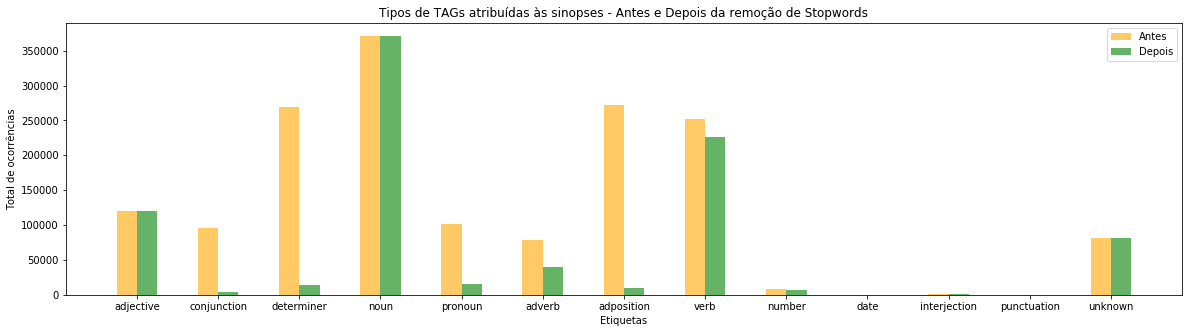

adjective=0.00039224850194452543
conjunction=0.9646964906568071
determiner=0.9477916283365797
noun=0.0007114407213577589
pronoun=0.8460196012699415
adverb=0.4909545483684852
adposition=0.9642519540229885
verb=0.10167733147491131
number=0.251313276026743
date=nan
interjection=0.0
punctuation=nan
unknown=0.0


C:\Users\LuisRicardoFerraz\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


In [6]:
etiquetasAntes = ('adjective_before','conjunction_before','determiner_before','noun_before','pronoun_before','adverb_before','adposition_before','verb_before','number_before','date_before','interjection_before','punctuation_before','unknown_before')
etiquetasDepois = ('adjective_after','conjunction_after','determiner_after','noun_after','pronoun_after','adverb_after','adposition_after','verb_after','number_after','date_after','interjection_after','punctuation_after','unknown_after')
eixoHorizontal = ('adjective','conjunction','determiner','noun','pronoun','adverb','adposition','verb','number','date','interjection','punctuation','unknown')

generateTagsPlot(etiquetasAntes,etiquetasDepois,eixoHorizontal,20,5,0.25,'Tipos de TAGs atribuídas às sinopses - Antes e Depois da remoção de Stopwords','Etiquetas','Total de ocorrências')

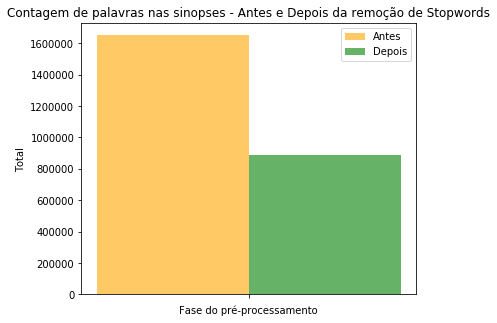

=0.4612252174029039


In [7]:
etiquetasAntesNew = ['total_before']
etiquetasDepoisNew = ['total_after']
eixoHorizontalNew = ['']

generateTagsPlot(etiquetasAntesNew,etiquetasDepoisNew,eixoHorizontalNew,6,5,0.25,'Contagem de palavras nas sinopses - Antes e Depois da remoção de Stopwords','Fase do pré-processamento','Total')